In [1]:
# 1. Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HeartDiseaseRDDProject").getOrCreate()
sc = spark.sparkContext

In [4]:
# 2. Load data as RDD
data_path = "/content/heart_cleveland.csv"  # adjust path if needed
rdd = sc.textFile(data_path)

In [5]:
# 3. Remove header row
header = rdd.first()
rdd_data = rdd.filter(lambda line: line != header)

In [6]:
# 4. Parse lines into floats (None for “?”) and build DataFrame for EDA
from pyspark.sql.types import StructType, StructField, DoubleType
columns = header.split(",")

def safe_parse(line):
    try:
        return [float(x) if x != "?" else None for x in line.split(",")]
    except:
        return None

rdd_parsed = rdd_data.map(safe_parse).filter(lambda x: x is not None and len(x) == 14)
schema = StructType([StructField(col, DoubleType(), True) for col in columns])
df = spark.createDataFrame(rdd_parsed, schema)


In [7]:
# 5. Show first 5 rows
df.show(5)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|condition|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---------+
|69.0|1.0|0.0|   160.0|234.0|1.0|    2.0|  131.0|  0.0|    0.1|  1.0|1.0| 0.0|      0.0|
|69.0|0.0|0.0|   140.0|239.0|0.0|    0.0|  151.0|  0.0|    1.8|  0.0|2.0| 0.0|      0.0|
|66.0|0.0|0.0|   150.0|226.0|0.0|    0.0|  114.0|  0.0|    2.6|  2.0|0.0| 0.0|      0.0|
|65.0|1.0|0.0|   138.0|282.0|1.0|    2.0|  174.0|  0.0|    1.4|  1.0|1.0| 0.0|      1.0|
|64.0|1.0|0.0|   110.0|211.0|0.0|    2.0|  144.0|  1.0|    1.8|  1.0|0.0| 0.0|      0.0|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---------+
only showing top 5 rows



In [8]:
# 6. Statistical summary
df.describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|                sex|                cp|          trestbps|              chol|               fbs|           restecg|           thalach|             exang|           oldpeak|             slope|                ca|              thal|         condition|
+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              297|                297|               297|               297|               297|               297|               297|               297|           

In [9]:
# 7. Count missing values per column
from pyspark.sql.functions import col
df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]) \
  .groupBy().sum().show()

+--------+--------+-------+-------------+---------+--------+------------+------------+----------+------------+----------+-------+---------+--------------+
|sum(age)|sum(sex)|sum(cp)|sum(trestbps)|sum(chol)|sum(fbs)|sum(restecg)|sum(thalach)|sum(exang)|sum(oldpeak)|sum(slope)|sum(ca)|sum(thal)|sum(condition)|
+--------+--------+-------+-------------+---------+--------+------------+------------+----------+------------+----------+-------+---------+--------------+
|       0|       0|      0|            0|        0|       0|           0|           0|         0|           0|         0|      0|        0|             0|
+--------+--------+-------+-------------+---------+--------+------------+------------+----------+------------+----------+-------+---------+--------------+



In [10]:
# 8. Check for duplicate rows
distinct_count = df.distinct().count()
original_count = df.count()
print(f"Original rows: {original_count}, Distinct rows: {distinct_count}")

Original rows: 297, Distinct rows: 297


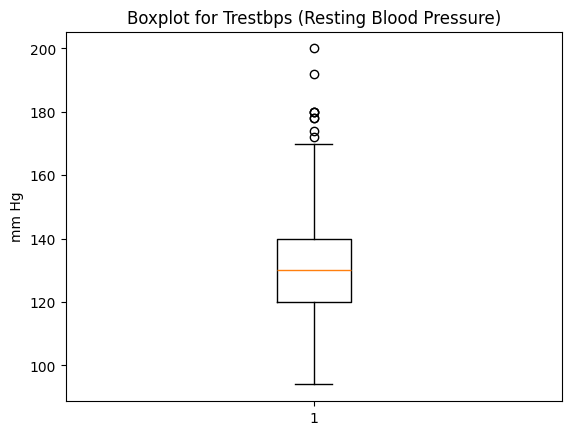

In [11]:
# 9. Plot boxplot to detect outliers for 'trestbps'
import matplotlib.pyplot as plt
bp_data = df.select("trestbps") \
    .rdd.flatMap(lambda x: x) \
    .filter(lambda x: x is not None) \
    .collect()

plt.boxplot(bp_data)
plt.title("Boxplot for Trestbps (Resting Blood Pressure)")
plt.ylabel("mm Hg")
plt.show()

In [12]:
# 10. Prepare data for MLlib: remove rows with any missing values
clean_rdd = rdd_parsed.filter(lambda row: None not in row)

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

data_labeled = clean_rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[:-1])))

In [13]:
# 11. Split into training and testing sets
train_data, test_data = data_labeled.randomSplit([0.7, 0.3], seed=42)

In [14]:
# 12. Train Logistic Regression model
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
model = LogisticRegressionWithLBFGS.train(train_data)

In [15]:
# 13. Make predictions on test set
predictions = test_data.map(lambda p: (p.label, model.predict(p.features)))

In [16]:
# 14. Evaluate model accuracy
correct = predictions.filter(lambda x: x[0] == x[1]).count()
total = test_data.count()
accuracy = correct / total
print(f"Model accuracy: {accuracy:.2f} ({correct}/{total})")

Model accuracy: 0.84 (69/82)


In [19]:
import joblib
joblib.dump(model, 'my_model.pkl')   #  Save the model

['my_model.pkl']

In [ ]:
# 15. Interactive prediction for a new patient
def get_patient_data():
    print("Enter details for a new patient:")
    age      = float(input("Age: "))
    sex      = float(input("Sex (1=male, 0=female): "))
    cp       = float(input("Chest pain type (0-3): "))
    trestbps = float(input("Resting blood pressure (mm Hg): "))
    chol     = float(input("Serum cholesterol (mg/dl): "))
    fbs      = float(input("Fasting blood sugar >120 mg/dl? (1=yes, 0=no): "))
    restecg  = float(input("Resting ECG results (0-2): "))
    thalach  = float(input("Max heart rate achieved: "))
    exang    = float(input("Exercise-induced angina (1=yes, 0=no): "))
    oldpeak  = float(input("ST depression induced by exercise: "))
    slope    = float(input("Slope of peak exercise ST segment (0-2): "))
    ca       = float(input("Number of major vessels (0-3): "))
    thal     = float(input("Thalassemia (1=normal,2=fixed,3=reversible): "))
    return [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]

new_data = get_patient_data()
new_vector = Vectors.dense(new_data)
prediction = model.predict(new_vector)

if prediction > 0:
    print("Prediction: The patient has heart disease.")
else:
    print("Prediction: The patient does NOT have heart disease.")

Enter details for a new patient:
